# testing the best model 

In [5]:
import os 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,mean_absolute_error,r2_score,mean_squared_error
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow 
import mlflow.sklearn
import numpy as np 
from mlProject.constants import * 
from mlProject.utils.common import read_yaml, create_directories

In [8]:
%pwd 

'd:\\pythonProjects\\MLflow_ML_project\\research'

In [9]:
import os 
os.chdir('../')
%pwd

'd:\\pythonProjects\\MLflow_ML_project'

In [10]:
def evaluation_metrics(actual,pred):
    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae=mean_absolute_error(actual,pred)
    r2=r2_score(actual,pred)
    return rmse,mae,r2 


In [13]:
config=read_yaml(CONFIG_FILE_PATH)
params=read_yaml(PARAMS_FILE_PATH)
print(params.Hyperopt_params.alpha[0])

[2025-01-06 06:01:31,115: INFO:common: yaml file: config\config.yaml loaded successfully]
[2025-01-06 06:01:31,117: INFO:common: yaml file: params.yaml loaded successfully]
0.01


In [28]:
# entity
from dataclasses import dataclass

@dataclass(frozen=True)
class HyperOptParams:
    root_dir: Path
    train_data_path: Path 
    test_data_path: Path
    model_name: str
    alpha: list 
    l1_ratio: list 
    target_column: str
    max_eval: int  

In [29]:
# configuration 
class HyperOptParamsConfigManager:
    def __init__(
            self,
            config_file_path=CONFIG_FILE_PATH,
            params_file_path=PARAMS_FILE_PATH,
            schema_file_path=SCHEMA_FILE_PATH,
            ):
        self.config=read_yaml(config_file_path)
        self.params=read_yaml(params_file_path)
        self.schema=read_yaml(schema_file_path)
    
    def get_hyperopt_config(self)->HyperOptParams:
        config=self.config.model_trainer 
        params=self.params.Hyperopt_params
        schema=self.schema.TARGET_COLUMN

        hypoeropt_config=HyperOptParams(
            root_dir=config.root_dir,
            train_data_path=config.train_data_path,
            test_data_path=config.test_data_path,
            model_name=config.model_name,
            alpha=params.alpha,
            l1_ratio=params.l1_ratio,
            max_eval=params.max_eval,
            target_column=schema.name
        )
        return hypoeropt_config

        

In [78]:
# components
from hyperopt import STATUS_OK,hp,fmin, tpe, Trials
import dagshub
from functools import partial

class hyperOptTraining:
    def __init__(self,config=HyperOptParams):
        self.config=config

    def objective(self,params,xtrain,ytrain,xtest,ytest):
        """ 
        """
        with mlflow.start_run():
            mlflow.set_tag('model','ElasticNet')
            

            lr=ElasticNet(**params)
            lr.fit(xtrain,ytrain)
            ypred=lr.predict(xtest)
            mlflow.log_params(lr.get_params())
            rmse,mae,r2=evaluation_metrics(ytest,ypred)
            mlflow.log_metrics({'rmse':rmse,'mse': mae, 'r2':r2})
        return {'loss':rmse,'status':STATUS_OK}
    
    def train(self):
        train_data=pd.read_csv(self.config.train_data_path)
        test_data=pd.read_csv(self.config.test_data_path)

        xtrain=train_data.drop([self.config.target_column],axis=1)
        xtest=test_data.drop([self.config.target_column],axis=1)
        ytrain=train_data[[self.config.target_column]]
        ytest=test_data[[self.config.target_column]]

        search_space={
            'alpha': hp.uniform('alpha',self.config.alpha[0],self.config.alpha[1]),
            'l1_ratio':hp.uniform('l1_ratio',self.config.l1_ratio[0],self.config.l1_ratio[1])
        }
        dagshub.init(repo_owner='Immortal-Pi', repo_name='ML-project-with-MLFlow', mlflow=True)
        experiment_name = "hyperopt_test_2"
        existing_experiment = mlflow.get_experiment_by_name(experiment_name)

        if existing_experiment is None:
            experiment_id = mlflow.create_experiment(name=experiment_name,artifact_location='hyperopt-test')
        else:
            experiment_id = existing_experiment.experiment_id
        mlflow.set_experiment(experiment_id=experiment_id)

        trials=Trials()
        best_results=fmin(
            fn=partial(
                self.objective,
                xtrain=xtrain,
                ytrain=ytrain,
                xtest=xtest,
                ytest=ytest
            ),
            space=search_space,
            algo=tpe.suggest,
            max_evals=self.config.max_eval,
            trials=trials
        )
        return best_results,trials
    
    def register_best_model(self,best_results,trials):
        best_index=np.argmin([trial['result']['loss'] for trial in trials.trials])
        best_model=trials.trials[best_index]['result']['loss']

        with mlflow.start_run() as run:
            mlflow.sklearn.log_model(sk_model=best_model,artifact_path='best_model')
            mlflow.log_params(trials.trials[best_index]['mics']['vals'])
            model_uri=f'runs:{run.info.run_id}/best_model'
            mlflow.register_model(model_uri=model_uri,name='best_model')


        


In [80]:
# pipeline 
try: 
    config=HyperOptParamsConfigManager()
    hyperopt_config=config.get_hyperopt_config()
    hyperopt_config_training=hyperOptTraining(config=hyperopt_config)
    best_results,trails=hyperopt_config_training.train()
    #hyperopt_config_training.register_best_model(best_results,trails)
except Exception as e:
    raise e 

[2025-01-06 09:26:21,825: INFO:common: yaml file: config\config.yaml loaded successfully]
[2025-01-06 09:26:21,827: INFO:common: yaml file: params.yaml loaded successfully]
[2025-01-06 09:26:21,831: INFO:common: yaml file: schema.yaml loaded successfully]
[2025-01-06 09:26:22,158: INFO:_client: HTTP Request: GET https://dagshub.com/api/v1/repos/Immortal-Pi/ML-project-with-MLFlow "HTTP/1.1 200 OK"]


Initialized MLflow to track repo "Immortal-Pi/ML-project-with-MLFlow"

[2025-01-06 09:26:22,162: INFO:helpers: Initialized MLflow to track repo "Immortal-Pi/ML-project-with-MLFlow"]


Repository Immortal-Pi/ML-project-with-MLFlow initialized!

[2025-01-06 09:26:22,164: INFO:helpers: Repository Immortal-Pi/ML-project-with-MLFlow initialized!]
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?][2025-01-06 09:26:22,429: INFO:tpe: build_posterior_wrapper took 0.000000 seconds]
[2025-01-06 09:26:22,431: INFO:tpe: TPE using 0 trials]
 10%|█         | 1/10 [00:00<00:06,  1.48trial/s, best loss: 0.7722402670893089][2025-01-06 09:26:23,107: INFO:tpe: build_posterior_wrapper took 0.000000 seconds]
[2025-01-06 09:26:23,108: INFO:tpe: TPE using 1/1 trials with best loss 0.772240]
 20%|██        | 2/10 [00:01<00:05,  1.50trial/s, best loss: 0.7621722011677887][2025-01-06 09:26:23,764: INFO:tpe: build_posterior_wrapper took 0.000000 seconds]
[2025-01-06 09:26:23,765: INFO:tpe: TPE using 2/2 trials with best loss 0.762172]
 30%|███       | 3/10 [00:04<00:11,  1.64s/trial, best loss: 0.7080876731679705][2025-01-06 09:26:26,562: INFO:tpe: build_posterior_wrapper took 0.000999 seconds]
[2025-01-06 09:26:26,562: INFO:tpe: TPE using 3/3 tria

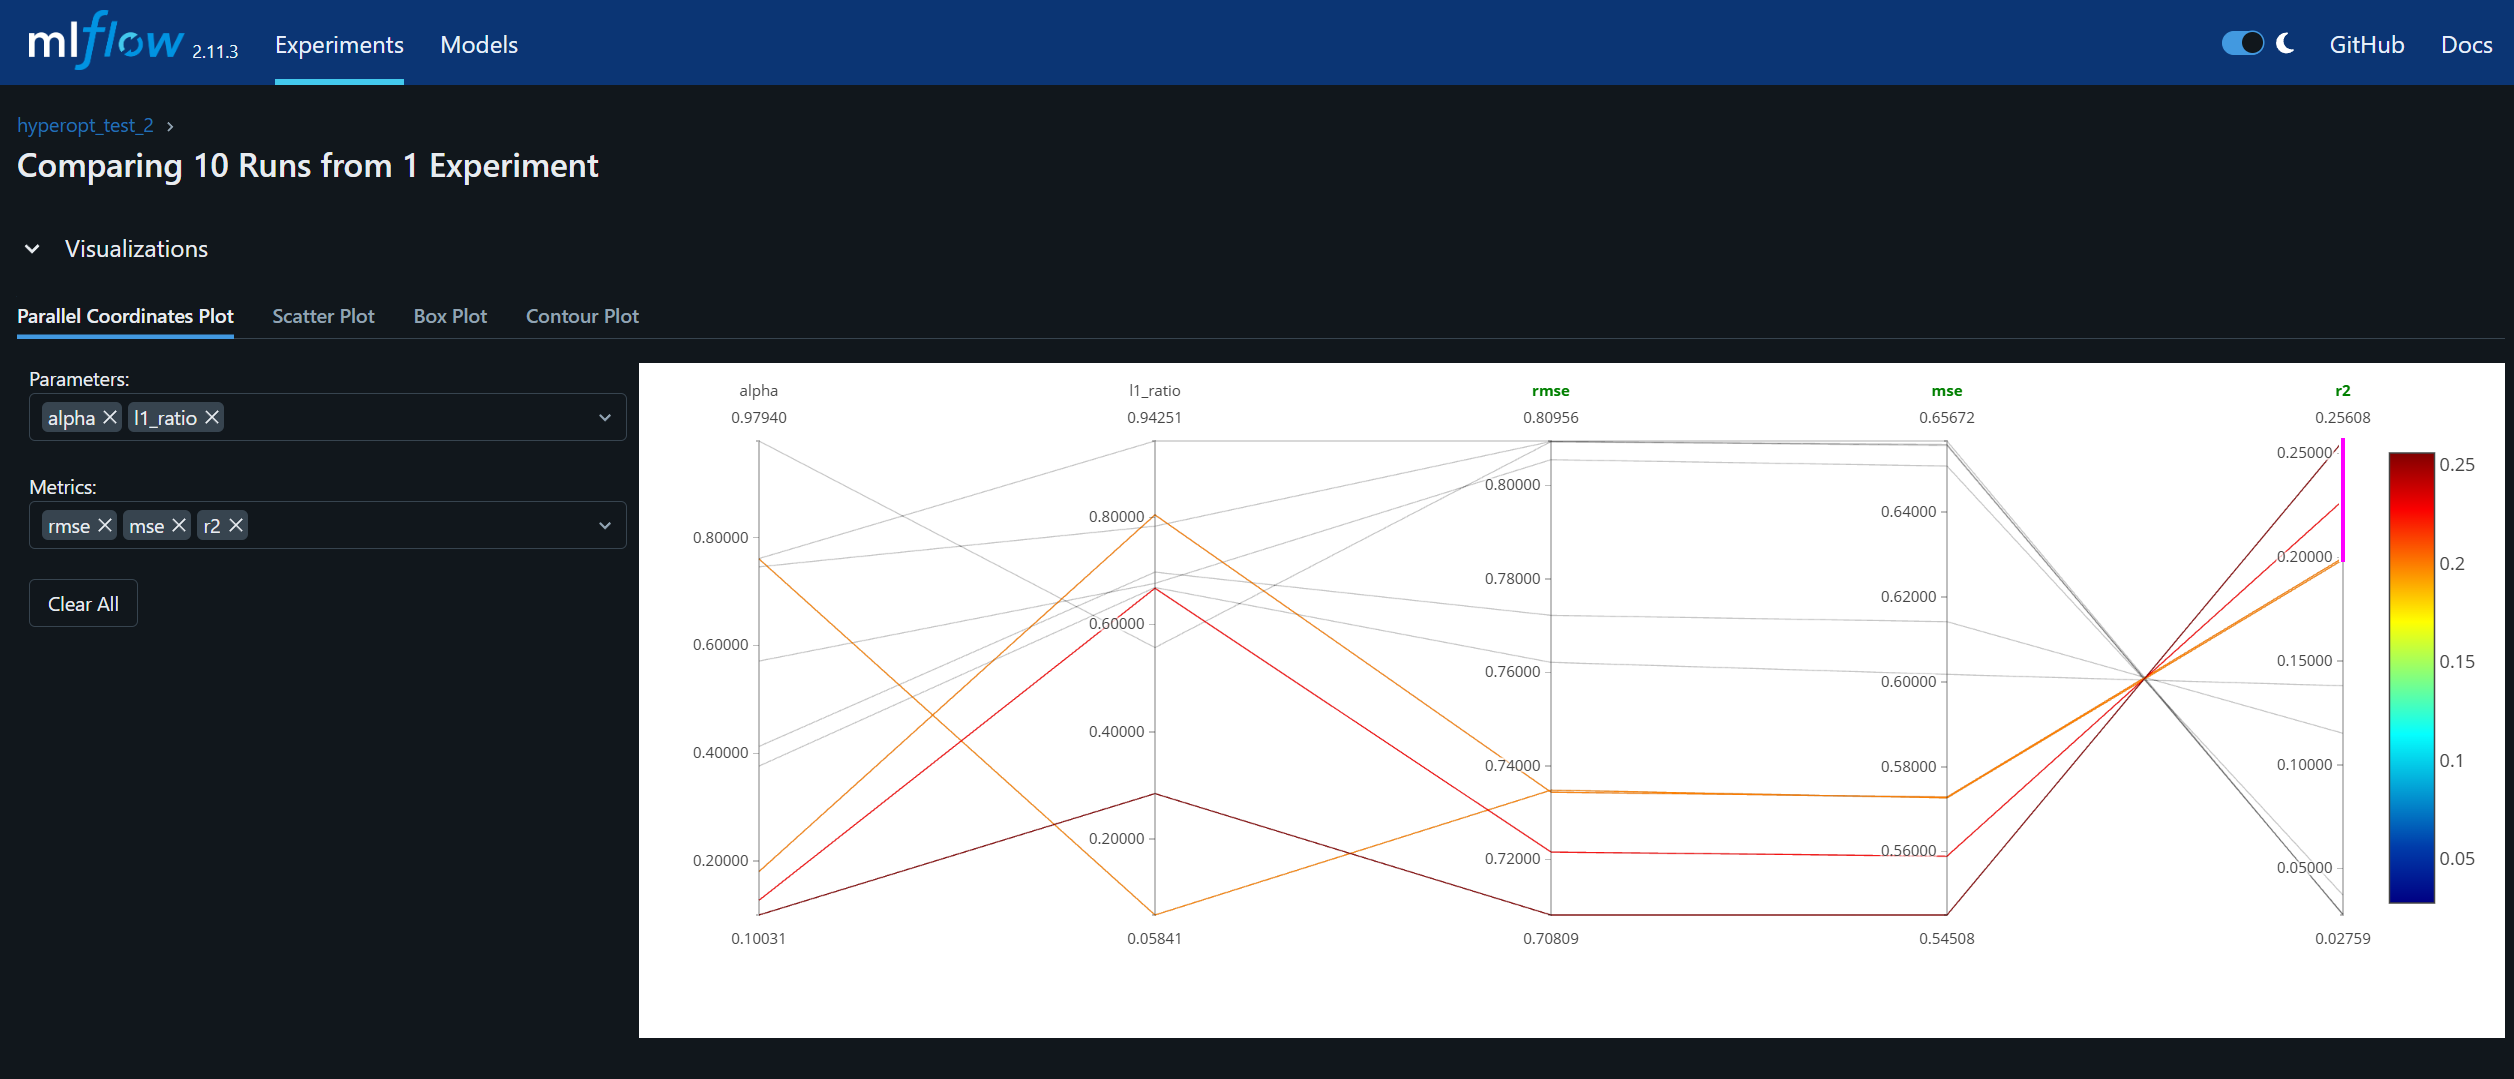

# sklearn pipeline 

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from typing import Dict, List, Optional


def get_sklearn_pipeline(numerical_features: List[str], categorical_features: Optional[List[str]]=[])-> Pipeline:
    preprocessing=ColumnTransformer(
        transformers=[
            ('numerical',SimpleImputer(strategy='median'),numerical_features),
            ('categorical',OneHotEncoder(),categorical_features)
        ]
    )
    pipeline=Pipeline(
        steps=[
            ('preprocessing',preprocessing),
            ('model',ElasticNet())
        ]
    )
    return pipeline


In [91]:
df=pd.read_csv('archive/wine-quality/WineQT.csv')

xtrain,xtest,ytrain,ytest=train_test_split(df.drop(columns=['Id','quality'],axis=1),df['quality'],test_size=0.2,random_state=42)

numerical_features=[f for f in df.drop(columns=['Id','quality'],axis=1)]


pipeline=get_sklearn_pipeline(numerical_features)
pipeline.fit(xtrain,ytrain)
pred=pipeline.predict(xtest)
pred

array([5.80174074, 5.57877714, 5.33959801, 5.7125553 , 5.78552521,
       5.77336356, 5.67201647, 5.54634607, 5.66796258, 5.53823831,
       5.53418442, 5.59904656, 5.77336356, 5.74093249, 5.78957909,
       5.48553782, 5.76525579, 5.80579463, 5.76525579, 5.73687861,
       5.79363298, 5.80579463, 5.42878345, 5.69228589, 5.72471695,
       5.62336986, 5.79363298, 5.76120191, 5.67201647, 5.69633977,
       5.79363298, 5.70039365, 5.78147133, 5.70444754, 5.63147763,
       5.38419073, 5.59093879, 5.77336356, 5.59904656, 5.32743636,
       5.72877084, 5.77336356, 5.58688491, 5.74498637, 5.74498637,
       5.75309414, 5.64769317, 5.7125553 , 5.25446645, 5.76120191,
       5.74498637, 5.64769317, 5.72066307, 5.65174705, 5.55850772,
       5.66796258, 5.69228589, 5.71660919, 5.76525579, 5.71660919,
       5.7125553 , 5.77741744, 5.67201647, 5.78147133, 5.75714802,
       5.6395854 , 5.70850142, 5.688232  , 5.49364559, 5.76120191,
       5.78147133, 5.76525579, 5.4166218 , 5.72877084, 5.70850